<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Purpose</a></span></li></ul></li><li><span><a href="#Business-Problem" data-toc-modified-id="Business-Problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Business Problem</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Useful-Scripts" data-toc-modified-id="Useful-Scripts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Useful Scripts</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Class-Distribution" data-toc-modified-id="Class-Distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Class Distribution</a></span></li><li><span><a href="#EDA-for-Text-Data" data-toc-modified-id="EDA-for-Text-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>EDA for Text Data</a></span></li><li><span><a href="#Total-Time-Taken" data-toc-modified-id="Total-Time-Taken-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Total Time Taken</a></span></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Description
This project uses the [consumer complaint database](https://catalog.data.gov/dataset/consumer-complaint-database).

## Data Description
The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.

## Purpose
Classify consumer complaints into predefined categories.

Classification algorithms
- Linear Support Vector Machine (LinearSVM)
- Multinomial Naive Bayes 
- Logistic Regression.

# Business Problem

<div class="alert alert-block alert-success">
<b>Business Problem:</b>  <br>
Task &nbsp;&nbsp; : Find the category of given complaint. <br>
Metric : IF-IDF <br>
Cleaning: Remove punctuations, expand contractions, etc <br>
Question: Which class the given complaint belongs to?
</div>

Note: To load the serialized object make sure you have the 
same conda environment as it was when creating the serialized object.
</div>


**Term Frequency** : This gives how often a given word appears within a document.

$\mathrm{TF}=\frac{\text { Number of times the term appears in the doc }}{\text { Total number of words in the doc }}$

**Inverse Document Frequency**: This gives how often the word appers across the documents.
If a term is very common among documents (e.g., “the”, “a”, “is”),
then we have low IDF score.

$\mathrm{DF}=\ln \left(\frac{\text { Number of docs }}{\text { Number docs the term appears in }}\right)$

**Term Frequency – Inverse Document Frequency TF-IDF**: 
TFIDF is the product of the TF and IDF scores of the term.

$\mathrm{TFIDF}=\frac{\mathrm{TF}}{\mathrm{DF}}$


In machine learning, TFIDF is obtained from the class `TfidfVectorizer`.
It has following parameters:

- `min_df`: remove the words from the vocabulary which have occurred in less than "min_df"
number of files.
- `max_df`: remove the words from the vocabulary which have occurred in more than _{ maxdf" }
total number of files in corpus.
- `sublinear_tf`: set to True to scale the term frequency in logarithmic scale.
- `stop_words`: remove the predefined stop words in 'english':
- `use_idf`: weight factor must use inverse document frequency.
- `ngram_range`: (1,2) to indicate that unigrams and bigrams will be considered.

# Imports

In [2]:
import time
time_start_notebook = time.time()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot') 
SEED=100
pd.options.display.max_colwidth = None

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

import sklearn
import tqdm

print([(x.__name__,x.__version__) for x in 
 [np,pd,sns,sklearn,tqdm,nltk]])

[('numpy', '1.18.4'), ('pandas', '1.1.0'), ('seaborn', '0.11.0'), ('sklearn', '0.23.1'), ('tqdm', '4.50.0'), ('nltk', '3.5')]


# Useful Scripts

In [3]:
def add_text_barplot(ax, decimals=4, rot=30,percent=False,comma=False):
    assert hasattr(ax,'patches')
    for p in ax.patches:
        txt = f"{p.get_height():,.2f}"
        txt = np.round(p.get_height(), decimals=decimals)
        
        if comma:
            if (int(txt)==txt):
                txt = "{:,}".format(int(txt))
            else:
                txt = "{:,.2f}".format(txt)

        txt = str(txt) + '%' if percent else txt
        x = p.get_x()+p.get_width()/2.
        y = p.get_height()
        ax.annotate(txt, (x,y), ha='center', va='center', 
                xytext=(0, 10), rotation=rot,textcoords='offset points')

# Load the data

In [4]:
df = pd.read_csv('../data/complaints_2019_clean.csv.zip',compression='zip')
df.head(1).append(df.tail(1))

product  \
0       Debt collection   
124906  Debt collection   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# Class Distribution

In [5]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    58529
Debt collection                                                                 23981
Credit card or prepaid card                                                     12531
Mortgage                                                                        10036
Checking or savings account                                                      7354
Student loan                                                                     4282
Vehicle loan or lease                                                            2930
Money transfer, virtual currency, or money service                               2835
Payday loan, title loan, or personal loan                                        2429
Name: product, dtype: int64

In [6]:
df['product'].nunique()

9

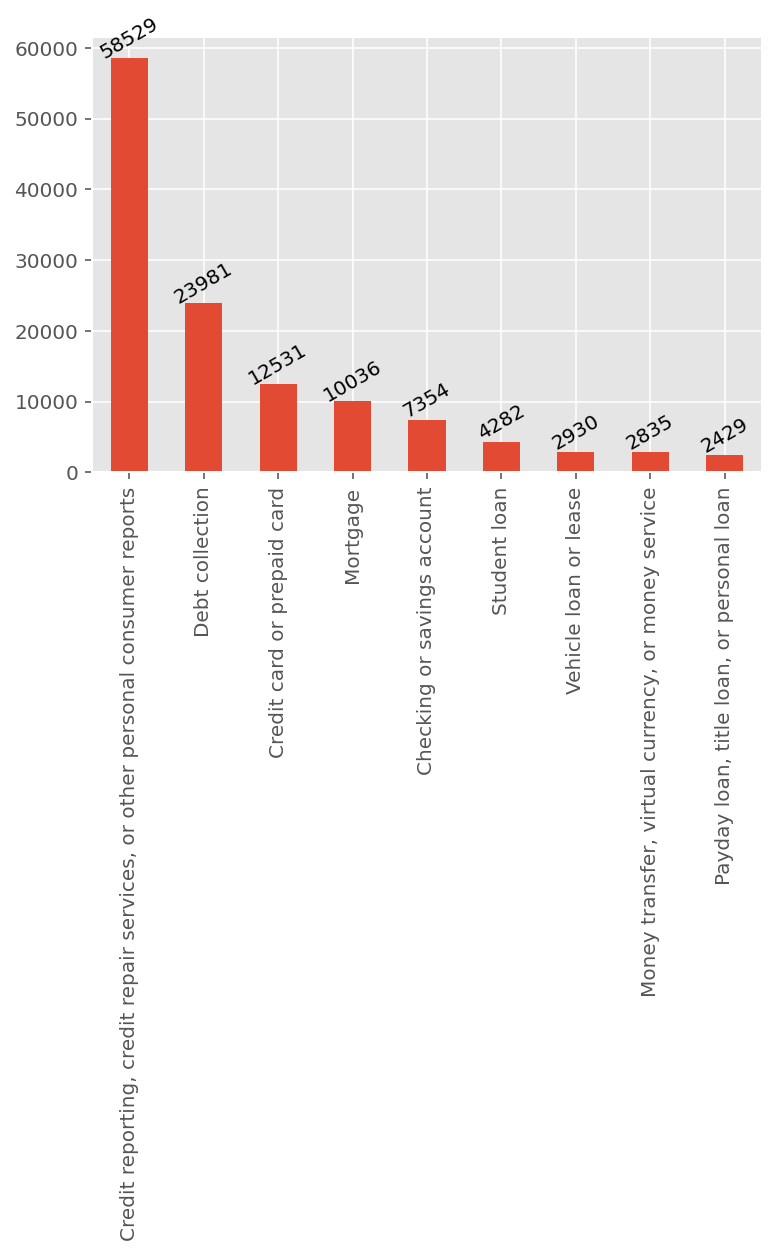

In [7]:
ax = df['product'].value_counts().plot.bar()
add_text_barplot(ax)
plt.savefig('../images/category_distribution.png',dpi=300)

In [8]:
df['category_id'] = df['product'].astype('category').cat.codes

df['category_id'].head()

0    3
1    3
2    3
3    2
4    2
Name: category_id, dtype: int8

In [9]:
dic_id_to_product = dict(enumerate(df['product'].unique()))
dic_id_to_product

{0: 'Debt collection',
 1: 'Credit reporting, credit repair services, or other personal consumer reports',
 2: 'Money transfer, virtual currency, or money service',
 3: 'Mortgage',
 4: 'Student loan',
 5: 'Credit card or prepaid card',
 6: 'Checking or savings account',
 7: 'Payday loan, title loan, or personal loan',
 8: 'Vehicle loan or lease'}

In [10]:
dic_product_to_id = {v:k for k,v in dic_id_to_product.items()}
dic_product_to_id

{'Debt collection': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Money transfer, virtual currency, or money service': 2,
 'Mortgage': 3,
 'Student loan': 4,
 'Credit card or prepaid card': 5,
 'Checking or savings account': 6,
 'Payday loan, title loan, or personal loan': 7,
 'Vehicle loan or lease': 8}

# EDA for Text Data

In [11]:
# make data small for eda
df = df.sample(n=2000,random_state=SEED)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# help(TfidfVectorizer())

In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
tfidf

TfidfVectorizer(min_df=5, ngram_range=(1, 2), stop_words='english',
                sublinear_tf=True)

In [14]:
# transform each complaint into a vector
features = tfidf.fit_transform(df['complaint_clean']).toarray()

labels = df['category_id']

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 2000 complaints is represented by 5204 features (TF-IDF score of unigrams and bigrams)


In [15]:
from sklearn.feature_selection import chi2
from tqdm import tqdm

def get_top_N_correlated(N=4,dic_product_to_id=dic_product_to_id):
    products,top_uni,top_bi = [],[],[]
    for product, category_id in sorted(dic_product_to_id.items()):
        features_chi2 = chi2(features, labels == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        products.append(product)
        top_uni.append(', '.join(unigrams[-N:]))
        top_bi.append(', '.join(bigrams[-N:]))

    df_top_corr = pd.DataFrame({'product': products,
                                'unigram': top_uni,
                                'bigram': top_bi})

    return df_top_corr

df_top_corr = get_top_N_correlated(N=4)
df_top_corr.style.set_caption('Top Correlated Terms per Category')

,product,unigram,bigram
0,Checking or savings account,"stressful, payday, lending, loan","loan agreement, loan day, predatory lending, received loan"
1,Credit card or prepaid card,"modification, foreclosure, escrow, mortgage","mortgage company, loan modification, escrow account, mortgage payment"
2,"Credit reporting, credit repair services, or other personal consumer reports","citi, express, reward, card","balance transfer, fraudulent charge, american express, credit card"
3,Debt collection,"overdraft, deposit, deposited, branch","direct deposit, overdraft fee, checking account, saving account"
4,"Money transfer, virtual currency, or money service","inquiry, reporting, equifax, report","credit file, fraudulent account, credit bureau, credit report"
5,Mortgage,"midland, collect, collection, debt","belong identity, collection agency, debt belong, collect debt"
6,"Payday loan, title loan, or personal loan","university, student, forgiveness, navient","federal loan, loan navient, student loan, loan forgiveness"
7,Student loan,"seller, transfer, ticket, paypal","money account, transfer fund, money order, paypal account"
8,Vehicle loan or lease,"gm, car, vehicle, leased","auto loan, vehicle returned, pay car, gm financial"


# Total Time Taken

In [16]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 0 min 8 secs
